In [165]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [167]:
# Load and preprocess the data
data = pd.read_csv('housing.csv')
data = data.dropna(subset=['total_bedrooms'])
data = pd.get_dummies(data, columns=['ocean_proximity']) 
changed_columns = [col for col in data.columns if col.startswith('ocean_proximity_')]
data[changed_columns] = data[changed_columns].astype(float)

In [169]:
correlation_matrix = data.corr()
#print(correlation_matrix)


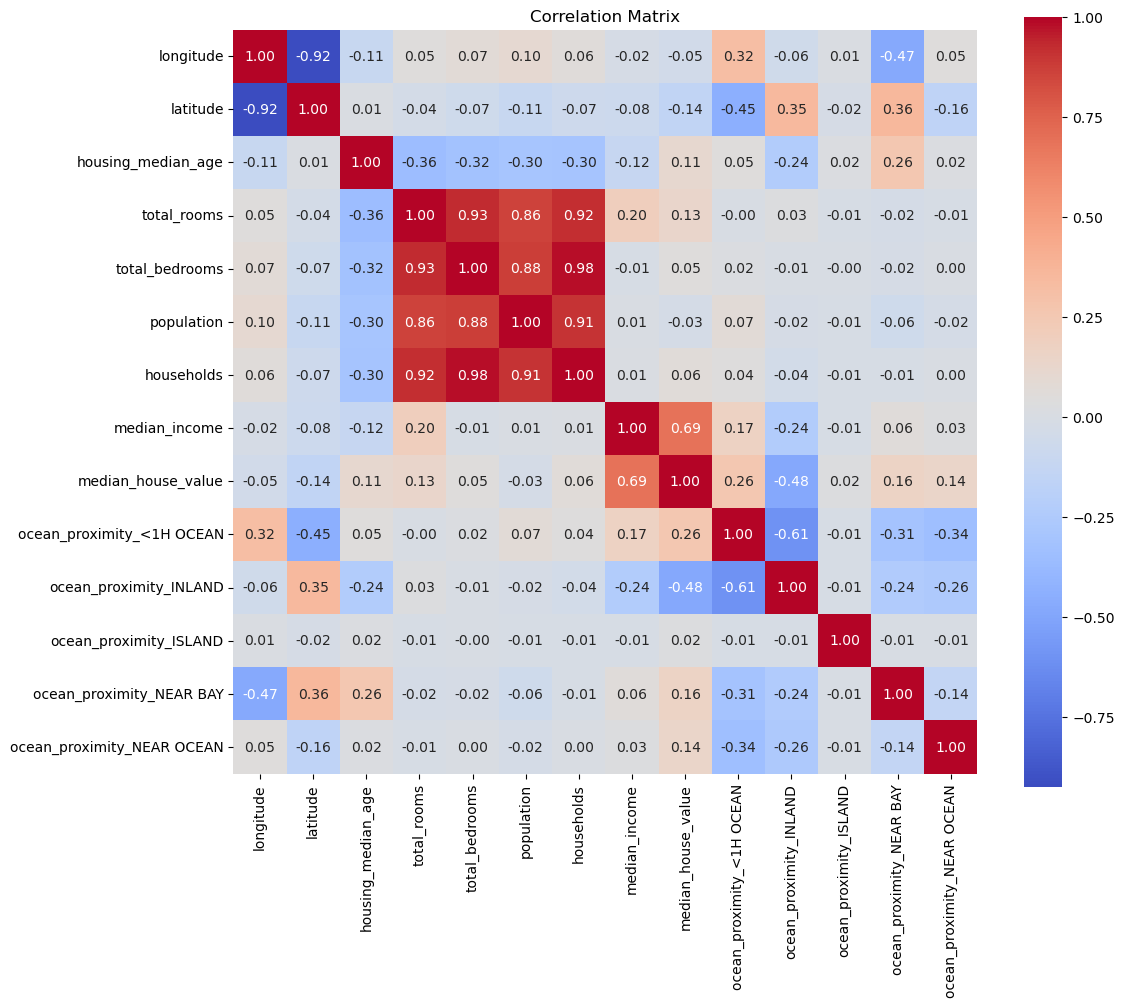

In [171]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix")
plt.show()



In [172]:
target_corr = correlation_matrix['median_house_value'].sort_values(ascending=False)
print(target_corr)


median_house_value            1.000000
median_income                 0.688355
ocean_proximity_<1H OCEAN     0.257614
ocean_proximity_NEAR BAY      0.160526
ocean_proximity_NEAR OCEAN    0.140378
total_rooms                   0.133294
housing_median_age            0.106432
households                    0.064894
total_bedrooms                0.049686
ocean_proximity_ISLAND        0.023525
population                   -0.025300
longitude                    -0.045398
latitude                     -0.144638
ocean_proximity_INLAND       -0.484787
Name: median_house_value, dtype: float64


In [173]:
drop_columns = [
    'households',
    'total_bedrooms',
    'population',
    'longitude',
    'latitude',
    'ocean_proximity_ISLAND',
    'ocean_proximity_INLAND'
]
drop_columns = [col for col in drop_columns if col in data.columns]
data.drop(columns=drop_columns, inplace=True)

In [174]:
# Features and target
X = data.drop('median_house_value', axis=1)
y = data['median_house_value']

# Splittes the data in 60-20-20
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# PART 1

In [176]:
# manualy mean and std
def mean_std(series):
    values = list(series)
    mean = sum(values) / len(values)
    std = (sum((x - mean) ** 2 for x in values) / len(values)) ** 0.5
    return mean, std

In [177]:
X_mean_std = {}
for col in X_train.columns:
    mean, std = mean_std(X_train[col])
    X_mean_std[col] = (mean, std)

In [178]:
def normalize(df, mean_std_dict):
    df_norm = df.copy()
    for col in df.columns:
        mean, std = mean_std_dict[col]
        df_norm[col] = [(x - mean) / std for x in df[col]]
    return df_norm

X_train = normalize(X_train, X_mean_std)
X_val = normalize(X_val, X_mean_std)
X_test = normalize(X_test, X_mean_std)

y_mean, y_std = mean_std(y_train)
y_train_norm = [(val - y_mean) / y_std for val in y_train]

In [179]:
# Gradient Descent
def gradient_descent(weights_now, b_now, X, y, L):
    n_samples = len(X)
    n_features = len(X.columns)
    weights_gradient = [0.0] * n_features
    b_gradient = 0.0

    for i in range(n_samples):
        row = list(X.iloc[i])
        prediction = sum(w * x for w, x in zip(weights_now, row)) + b_now
        error = prediction - y[i]

        for j in range(n_features):
            weights_gradient[j] += (1 / n_samples) * row[j] * error
        b_gradient += (1 / n_samples) * error

    new_weights = [w - L * gw for w, gw in zip(weights_now, weights_gradient)]
    new_b = b_now - L * b_gradient

    return new_weights, new_b

In [180]:
# Predicting 
def predict(X, weights, bias):
    predictions = []
    for _, row in X.iterrows():
        pred = sum(w * x for w, x in zip(weights, row)) + bias
        predictions.append(pred)
    return predictions

In [181]:
# Initialized
n_features = X_train.shape[1]
weights = [0.0] * n_features
b = 0.0
L = 0.005
epochs = 500

train_mse = []
val_mse = []
start_time = time.time()

# Training loop
for epoch in range(epochs):
    weights, b = gradient_descent(weights, b, X_train, y_train_norm, L)

    train_pred_norm = predict(X_train, weights, b)
    train_pred = [p * y_std + y_mean for p in train_pred_norm]
    train_mse.append(mean_squared_error(y_train, train_pred))

    val_pred_norm = predict(X_val, weights, b)
    val_pred = [p * y_std + y_mean for p in val_pred_norm]
    val_mse.append(mean_squared_error(y_val, val_pred))

training_time = time.time() - start_time

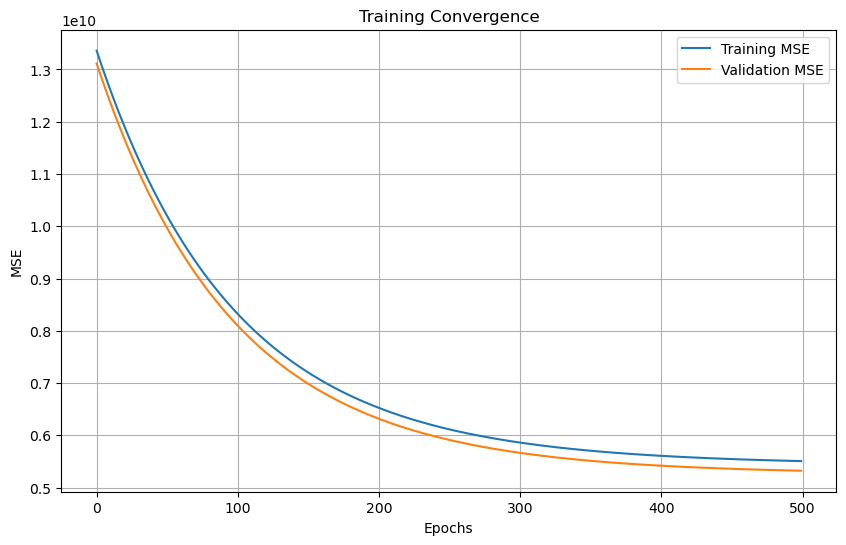

Training Time: 789.11 seconds

Train Metrics:
MSE: 5507142199.0146
MAE: 54364.4693
RMSE: 74210.1219
R2: 0.5902

Validation Metrics:
MSE: 5323238561.1177
MAE: 53864.6658
RMSE: 72960.5274
R2: 0.5966

Test Metrics:
MSE: 5256196180.2103
MAE: 53742.8448
RMSE: 72499.6288
R2: 0.5990



In [182]:
# Evaluating
def evaluate(X, y_true):
    pred_norm = predict(X, weights, b)
    pred = [p * y_std + y_mean for p in pred_norm]
    return {
        'MSE': mean_squared_error(y_true, pred),
        'MAE': mean_absolute_error(y_true, pred),
        'RMSE': (mean_squared_error(y_true, pred)) ** 0.5,
        'R2': r2_score(y_true, pred)
    }

# Final metrics
metrics = {
    'Train': evaluate(X_train, y_train),
    'Validation': evaluate(X_val, y_val),
    'Test': evaluate(X_test, y_test)
}

# Plotting convergence
plt.figure(figsize=(10, 6))
plt.plot(train_mse, label='Training MSE')
plt.plot(val_mse, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training Convergence')
plt.legend()
plt.grid(True)
plt.show()

# Print metrics
print(f"Training Time: {training_time:.2f} seconds\n")
for dataset in metrics:
    print(f"{dataset} Metrics:")
    for metric, value in metrics[dataset].items():
        print(f"{metric}: {value:.4f}")
    print()

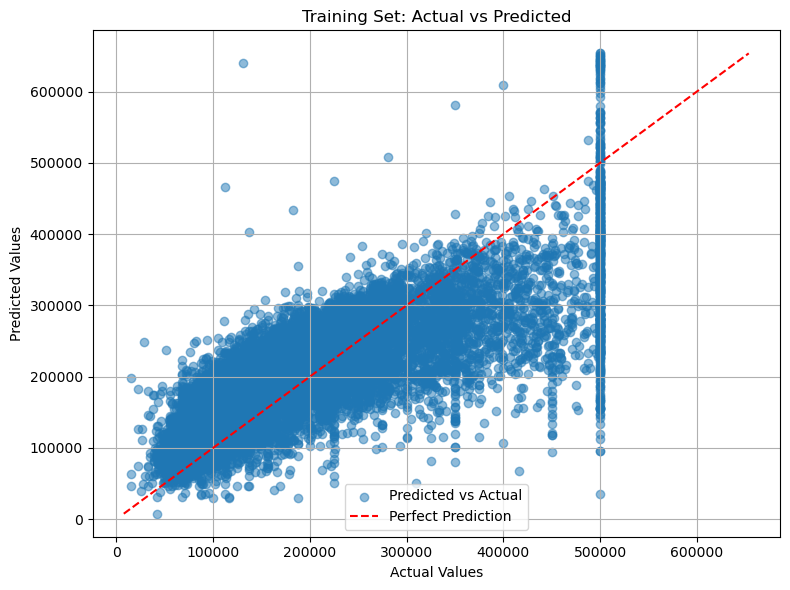

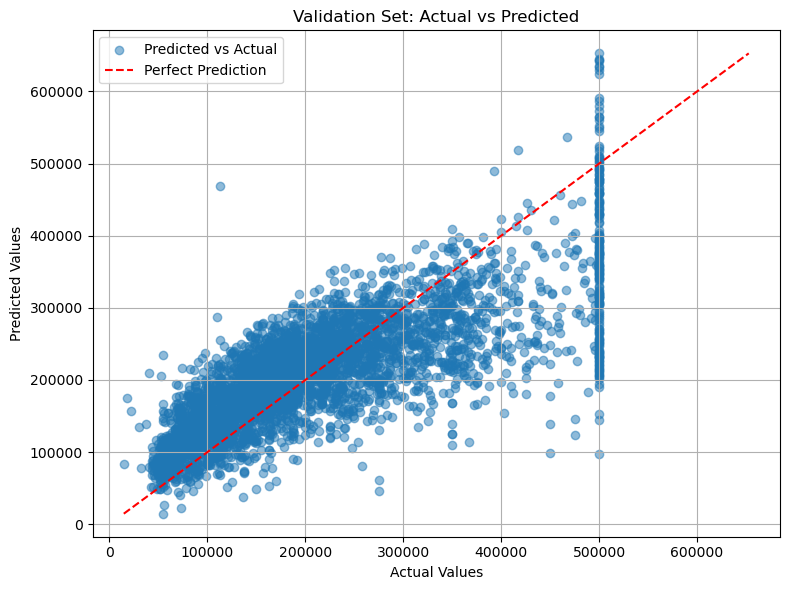

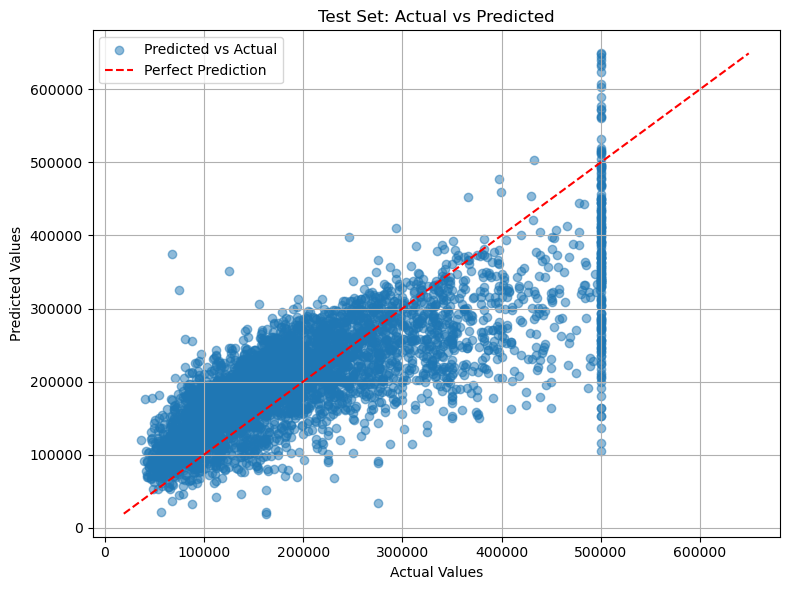

In [183]:
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, label='Predicted vs Actual')
    max_val = max(max(y_true), max(y_pred))
    min_val = min(min(y_true), min(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Predictions
train_pred = [p * y_std + y_mean for p in predict(X_train, weights, b)]
val_pred = [p * y_std + y_mean for p in predict(X_val, weights, b)]
test_pred = [p * y_std + y_mean for p in predict(X_test, weights, b)]

# Plots
plot_predictions(y_train, train_pred, "Training Set: Actual vs Predicted")
plot_predictions(y_val, val_pred, "Validation Set: Actual vs Predicted")
plot_predictions(y_test, test_pred, "Test Set: Actual vs Predicted")
